In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
import scipy.linalg as SLA
import torch.linalg as TLA
import math
import warnings
import seaborn as sns
from scipy.linalg import toeplitz
from utils import sample_PLN, log_stirling
warnings.filterwarnings("ignore")
torch.set_default_dtype(torch.float64)
import scipy
import time
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
#from sqrtm import sqrtm
import threading
from utils import C_from_Sigma,build_block_Sigma, log_stirling

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
device = torch.device('cpu')

In [4]:
def compare_models(dict_models,name_doss , save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the
    true parameters and the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model (MC_PLNPCA object where you
                      have called model.fit_IMPS()).
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the figure will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if save = True
    '''
    #best_model = MC_PLNPCA(q, batch_size, true_value = True)
    #best_model.init_data(Y_sampled, O, covariates)

    #get the max of all the likelihoods for a nice plot. We intialize the max with the likelihood of the 
    # model that has the true parameters (unknown in practice) 
    #best_log_like = best_model.compute_mean_log_likelihood(0.0001)
    #max_ = best_log_like
    max_ = 0 
    for name,model in dict_models.items():
        current_max = np.max(np.array(model.log_likelihood_list))
        max_ = max(max_,current_max)
    fig,ax = plt.subplots(3,1,figsize = (15,15))
    best_model = Basic_IMPS(q, average = 100, true_value = True)
    best_model.init_data(Y, O, covariates)
    best_model.Y_b,best_model.O_b, best_model.covariates_b, best_model.batch_size = Y, O, covariates, n
    best_log_like = best_model.infer_batch_p_theta(1000, 0.1, 1000)
    
    ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ')
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer')
    for name,model in dict_models.items() : 
        

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        

        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        
        ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_, label = name )
        ax[2].legend()
        ax[2].set_title('log_likelihood')
        ax[2].set_ylabel('log_likelihood')
        ax[2].set_yscale('symlog')
    
    ax[2].axhline(best_log_like-max_, c = 'red', label = 'best likelihood')
    plt.suptitle(name_doss)
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [45]:
def find_best_lr(optimizer,N_iter, acc, lrs, q, batch_size,average = 300):
    '''
    function that is supposed to find the best lr within a grid of lr (lrs) for 
    an optimizer to fit the MC_PLNPCA method. the metric used
    to discriminate each lr is the log likelihood. We parallelized the code to go faster. 
    
    args: otpimizer : should be an object of torch.optim., for example torch.optim.Rprop. 
    
        N_iter : int. The number of iterations you want to do when running the .fit_IMPS method.
    
        acc : float positive. the accuracy you want when running the .fit_IMPS method. 
        
        lrs : list. the grid of lr.
        
        q : the dimension q you want for the model. should be small.  
        
        batch_size : int. The batch_size you want  when running the .fit_IMPS method.
        
        average : int. the average argument for the model. 
        
        
        
    returns : the best lr according to the metric
    '''
    #initiate some lists.
    metrics = list()
    models = list()
    ts = list()
    # launch the models with the right lr. 
    #model = Basic_IMPS(q, average = average, true_value = False)
        
    #model.fit(Y,O,covariates,N_iter,0.001,0.01,        400, 0.1,          batch_size , optimizer)
    for lr in lrs: 
        model = Basic_IMPS(q, average = average, true_value = False)
        
        t = threading.Thread(target =model.fit,
                            args = [Y,O,covariates,N_iter,acc,lr,        300, 0.1,            batch_size, optimizer])
                                                          # acc    #N_iter_mode  lr_mode        # batch_size #class optimizer
        t.start()
        ts.append(t)
        models.append(model)
        
    # join each threading. 
    for t in ts: 
        t.join()
    # get the metrics for each model. 
    for i, model in enumerate(models) :
        metrics.append(np.mean(np.array(model.log_likelihood_list)))
    metrics = np.nan_to_num(np.array(metrics),-100000)
    argmax = np.argmax(metrics)#argmax of the metrics 
    best_lr = lrs[argmax]
    return best_lr, dict(zip(lrs,models)), models[argmax]  #the best lr, the dict in case 
                                                           # we need it to comopare, and the best model. 
    
#lrs =[0.0001, 0.001, 0.002,0.003, 0.0002, 0.0005, 0.0008] 
#best_lr, models, best_model = find_best_lr(torch.optim.Rprop,60, acc = 0.1, lrs = lrs, q = q, batch_size = 10,average = 300)

In [6]:
dict_optimizers = {'Adamax' : torch.optim.Adamax,
                   'Adadelta': torch.optim.Adadelta, 
                   'Adam': torch.optim.Adam, 
                   'Adagrad' : torch.optim.Adagrad,
                  'Rprop' : torch.optim.Rprop, 
                   'RMSprop' : torch.optim.RMSprop,
                  'SGD' : torch.optim.SGD}

In [7]:
#compare_models(models, '')

In [8]:
def launch_optimizers(dict_optimizers,N_iter,best_lrs, acc, q,batch_size,average = 300):
    '''
    launch some optimizers to fit the .fit_IMPS method of the Basic_IMPS object to compare them after. 
    args : 
         dict_optimizer : dictionnarie. dict that contains the optimizer. example: {'Rprop': torch.optim.Rprop}
         
         N_iter : int. the number of iteration you want the models to do for each optimizer. 
         
         best_lrs : list of float. the (best)learning rate of each optimizer.
    
         acc : positive float. the accuracy you want when running the .fit_IMPS method. 
         
         q : int. the dimension you want for the Basic_IMPS object. 
         
         batch_size : int. the batch_size you want. 
         
    return : a dict of model. The key are the name of the optimizer, the values are the models trained with 
            the corresponding optimizer. 
    '''
    print('best_lrs ', best_lrs)
    ts = list()  
    models = list()
    # lauch all the model with the right optimizer in a parallelized fashion. 
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        params = []
        for i,(name,optimizer)  in enumerate(dict_optimizers.items()): 
            
            params.append([Y,O,covariates,N_iter,acc,lr,        300, 0.1,            batch_size, optimizer])
        #did not have the choice to do this since I need to get the returned value back. 
        futures = [executor.submit(Basic_IMPS(q, average = average, true_value = False).fit, param[0],param[1],param[2],param[3],param[4],param[5],param[6]) for param in params]
        models =  [f.result() for f in futures]
    # return the dict with the corresponding values and keys. 
    return dict(zip(dict_optimizers.keys(), models))
# all_models = launch_optimizers()

In [9]:
def sample_gaussians(N_samples, mean,sqrt_Sigma):
    '''
    samples some gaussians with the right mean and variance. Be careful, we ask 
    for the square root of Sigma, not Sigma. will detect automatically if we are using batches or not.  
    '''
    q = mean.shape[0]
    if len(mean.shape)> 1 : 
        q = mean.shape[1]
        W_orig = torch.randn(N_samples, 1,q,1)
    elif len(mean.shape) == 1 : 
        W_orig = torch.randn(N_samples, q, 1)
    W = torch.matmul(sqrt_Sigma.unsqueeze(0), W_orig).squeeze() + mean.unsqueeze(0)
    return W

def log_gaussian_density(W, mu_p,Sigma_p): 
    '''
    computes the log density of a gaussian
    '''
    dim = W.shape[-1]
    const = torch.sqrt((2*math.pi)**dim*torch.det(Sigma_p))
    Wmoinsmu = W-mu_p.unsqueeze(0)
    inv_Sig = torch.inverse(Sigma_p)
    if len(mu_p.shape)>1 : 
        log_d = -1/2*torch.matmul(torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(3)).squeeze().unsqueeze(2), Wmoinsmu.unsqueeze(3))
    elif len(mu_p.shape)== 1 :  
        log_d = -1/2*torch.matmul(Wmoinsmu.unsqueeze(1),torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(2))).squeeze()
    return log_d.squeeze() - torch.log(const)



In [10]:
def sample_students(N_samples,mu,Sigma,nu):
    '''
    sample some variables from a student law with mean mu, variance sigma and nu degrees of freedom.
    '''
    sqrt_Sigma = torch.from_numpy(SLA.sqrtm(Sigma))
    normale = torch.randn(N_samples,1,q)
    num = torch.matmul(normale, sqrt_Sigma.unsqueeze(0)).squeeze()
    denom = torch.sum(torch.randn(nu,N_samples)**2,axis = 0)
    prod = torch.multiply(num, torch.sqrt(nu/denom).unsqueeze(1))
    return mu + prod


def student_density(W,mu,Sigma,nu):
    '''
    density of a student law. The student law has heavier tails than the gaussian, so we will
    avoid infinite variance. This function takes W of size either (N_s, q) or q. Returns the density 
    along the last axis. 
    '''
    q = W.shape[-1]
    const = math.gamma((nu+q)/2)
    const/= math.gamma(nu/2)
    const/= (nu*math.pi)**(q/2)
    const/= torch.sqrt(torch.det(Sigma))
    Wmoinsmu = W-mu
    if len(W.shape)>1:
        W_term = torch.matmul(torch.matmul(torch.inverse(Sigma).unsqueeze(0), Wmoinsmu.unsqueeze(2)).squeeze().unsqueeze(1),Wmoinsmu.unsqueeze(2))
    else : 
        W_term = Wmoinsmu@torch.inverse(Sigma)@Wmoinsmu
    return const*(1+W_term/nu)**(-(nu+q)/2)

def log_student_density(W,mu,Sigma,nu):
    return torch.log(student_density(W,mu,Sigma,nu))

In [11]:
def log_P_WgivenY(Y_i,covariates_i, O_i, W,C,beta):
    '''
    computes the log of the density of (W,Y_i) given Y_i. 
    args : 
        Y_i : tensor of size p 
        covariates_i : tensor of size d 
        O_i : tensor of size p 
        W : torch of size q. or (N_samples, q) should be a gaussian or a student. 
            if the dimension is (N_samples, q), we will return a vector of dimension N_samples
            in which each coordinate i will be the log posterior of W[i,:]. 
        Explanation of why we want two cases : we either want to compute the 
        log posterior of a lot of W, that is (N_samples,q), or we want to get the mode, 
        so that we only need one vector of size q. 

    return : the log of the probability of (W,Y_i) given Y_i. For the formula see MC_PLNPCA.ipynb
    '''
    length = len(W.shape)
    if length == 1 : 
        CW = W.reshape(1,-1)@(C.T)
    elif length == 2 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
    A_i = O_i +   CW +covariates_i@beta
    return -q/2*math.log(2*math.pi)-1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_i)   + A_i*Y_i - log_stirling(Y_i) , axis = -1).squeeze()     

def batch_log_P_WgivenY(Y_b, covariates_b, O_b, W, C, beta): 
    '''
    does the same as log_P_W_givenY but add one more dimension for computing this for a batch instead of 
    only one element. 
    '''
    length = len(W.shape)
    if length == 2 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
    elif length == 3 : 
        CW = torch.matmul(C.unsqueeze(0).unsqueeze(1), W.unsqueeze(3)).squeeze()
    A_b = O_b + CW + covariates_b@beta
    
    return -q/2*math.log(2*math.pi)-1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_b)   + A_b*Y_b - log_stirling(Y_b) , axis = -1)


In [25]:
class Basic_IMPS():
    def __init__(self, q,average = 50, true_value = False, sampler = 'gaussian'):
        self.sampler = sampler
        self.q = q
        self.average = average 
        self.true_value = true_value
        self.MSE_beta_list = list()
        self.MSE_Sigma_list = list()
        self.running_times = list()
        self.log_likelihood_list = list()
        self.last_likelihoods = list()
        self.log_likelihoods = list()
        self.norm_grad_log_beta_list = list()
        self.norm_grad_log_C_list = list()
        self.cmpt = 0 
        self.var_weights = np.array([])
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        torch.manual_seed(0)
        self.Y = Y.float()
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.last_betas = torch.zeros(self.average,self.d,self.p) # init of the average of the last betas
        self.last_Cs = torch.zeros(self.average, self.p, self.q) #init of the average of the last Sigmas
        # init C with an array of size (p,q)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        # init beta 
        self.beta = torch.randn(self.d,self.p)
        # if we want to take the true value of C and beta 
        if self.true_value : 
            self.C = torch.clone(true_C)
            self.beta = torch.clone(true_beta)
        #setting some gradients for optimization. 
        self.C.requires_grad_(True)
        self.beta.requires_grad_(True)
        self.C_mean = torch.clone(self.C)
        self.beta_mean = torch.clone(self.beta)
        
    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        #np.random.seed(2)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    ) 
        if last_batch_size != 0 : 
            if save_batch_size : 
                self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]]
                    )

        

    def keep_records(self,log_like): 
        '''
        function that keep some records in order to plot the evolution after.
        '''
        average_log_like = self.average_params(log_like)
        # keep the records of the norm of the gradients and the MSE wrt the true parameter
        self.norm_grad_log_beta_list.append((torch.norm(self.beta.grad)/(self.d*self.p)).item())
        self.norm_grad_log_C_list.append((torch.norm(self.C.grad)/(self.p*self.q)).item())
        self.MSE_beta_list.append(torch.mean((self.beta_mean -true_beta)**2).item())
        self.MSE_Sigma_list.append(torch.mean((self.C_mean@(self.C_mean.T) -true_Sigma_sampling)**2).item())
        self.running_times.append(time.time()-self.t0)
        #print('average log_like : ', average_log_like)
        self.log_likelihood_list.append(average_log_like)
        
    
    
    def average_params(self,log_like): 
        '''
        method that averages the parameters in order to smooth the variance. 
        We will take, for example, the last self.average betas computed to make 
        a better approximation of beta. We will do the same for C.
        This function adds the last parameters computed to update the mean of the parameter. 
        If we have not enough betas or Sigmas (less than self.average), the mean will be on those parameters. 
        args : 
            log_like : the likelihood computed with the current parameters.
        
        returns : 
                None but update the mean of the last self.average parameters.  
        '''
        
        self.cmpt +=1 # to keep track of the number of parameters we have for the mean
        # remove the oldest parameters and add the more recent one.
        self.last_betas[1:self.average] = torch.clone(self.last_betas[0: self.average-1].detach())
        self.last_betas[0] = torch.clone(self.beta.detach())
        self.last_Cs[1:self.average] = torch.clone(self.last_Cs[0: self.average-1].detach())
        self.last_Cs[0] = torch.clone(self.C.detach())
        self.last_likelihoods.append(log_like)
        # update the mean of the parameter
        
        # if we have enough parameters 
        if self.cmpt > self.average : 
            del(self.last_likelihoods[0])
            self.C_mean = torch.mean(self.last_Cs, axis = 0)
            self.beta_mean = torch.mean(self.last_betas, axis = 0)
            return np.mean(np.array(self.last_likelihoods))
        
        # if we don't have enough parameters. 
        else : 
            self.C_mean = torch.sum(self.last_Cs, axis = 0)/self.cmpt
            self.beta_mean = torch.sum(self.last_betas, axis = 0)/self.cmpt
            return np.mean(np.array(self.last_likelihoods))

        
    def scale_un_log_posterior(self): 
        # constante à tuner, en fonction de p logiquement, et peut etre data dependant
        self.missed_log_constant = 1*self.un_log_posterior(self.mode)

        def new_log_posterior(W): 
            return self.un_log_posterior(W) #- self.missed_log_constant
        self.scaled_log_posterior = new_log_posterior
    def scale_batch_un_log_posterior(self): 
        self.missed_batch_log_constant = 1*self.batch_un_log_posterior(self.batch_mode)
        def new_batch_log_posterior(W):
            return self.batch_un_log_posterior(W)# - self.missed_batch_log_constant

        self.scaled_batch_log_posterior = new_batch_log_posterior

    def get_weights(self,W):
        '''
        get the weights for the importance sampling. This function does not normalize the weights. 
        '''
        self.log_f = self.scaled_log_posterior(W)
        if self.sampler == 'gaussian':
            self.log_g = log_gaussian_density(W, self.mode, self.Sigma)
        elif self.sampler == 'student' : 
            self.log_g = log_student_density(W, self.mode, self.Sigma,  self.freedom)
            
        #print('log_f : old', self.log_f)
        #print('log_g old', self.log_g)
        log_fmoinslog_g = self.log_f -self.log_g
        
        return torch.exp(log_fmoinslog_g)


    

        
                    
    def find_mode(self, N_iter,lr): 
        def un_log_posterior(W): 
            return log_P_WgivenY(self.Y_i,self.covariates_i, self.O_i, W,self.C,self.beta)
        self.un_log_posterior = un_log_posterior
        W = torch.zeros(self.q)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        for i in range(N_iter): 
            loss = -self.un_log_posterior(W)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        self.mode = torch.clone(W)
        #print('mode :', self.mode)
        
    def find_batch_mode(self, N_iter, lr): 
        def batch_un_log_posterior(W): 
            return batch_log_P_WgivenY(self.Y_b, self.covariates_b, self.O_b, W, self.C, self.beta) 
        self.batch_un_log_posterior = batch_un_log_posterior
        W = torch.zeros(self.batch_size, self.q)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        for i in range(N_iter): 
            loss = -torch.mean(self.batch_un_log_posterior(W))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        self.batch_mode = torch.clone(W)
        
    def get_best_var(self):
        '''
        get the best var, i.e. the inverse of the hessian of the log of the integrand. 
        '''
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1))
        common = torch.exp(self.O_i + (self.mode.reshape(1,-1)@(self.C.T)).squeeze() +self.covariates_i@self.beta).unsqueeze(1).unsqueeze(2)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 0)+ torch.eye(self.q) 
        
        self.Sigma = torch.inverse(Hess_post.detach())
        self.sqrt_Sigma = TLA.cholesky(self.Sigma)
        #print('root :', self.sqrt_Sigma)
        #self.sqrt_Sigma = torch.from_numpy(SLA.sqrtm(self.Sigma))
        

        
    def fit(self, Y, O, covariates,  N_epoch, acc,lr,N_iter_mode, lr_mode, batch_size = 10, class_optimizer = torch.optim.Rprop):
        '''
        fit the data. We infer p_theta with importance sampling and then use pytorch autodifferentiation
        '''
        self.t0 = time.time()
        self.batch_size = batch_size
        self.acc = acc
        self.init_data(Y,O, covariates)# initialize the data. 
        self.optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        self.optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for j in tqdm(range(N_epoch)): 
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size): 
                self.Y_b, self.covariates_b, self.O_b = Y_b, covariates_b, O_b
                W_orig = torch.randn(N_samples, q) 
                loss =  -self.infer_batch_p_theta(N_iter_mode,lr_mode, N_samples)
                loss.backward()
                self.keep_records(-loss.item())
                self.C.grad=self.C.grad/torch.norm(self.C.grad)
                self.beta.grad= self.beta.grad/torch.norm(self.beta.grad)
                self.optim.step()
                self.optim.zero_grad()
                
        
    def infer_ptheta(self,  N_iter_mode, lr_mode, N_s):
        self.find_mode(N_iter_mode,lr_mode)
        self.scale_un_log_posterior()
        self.get_best_var()
        if self.sampler == 'gaussian' : 
            samples = sample_gaussians(N_s, self.mode, self.sqrt_Sigma)
        elif self.sampler == 'student' : 
            samples = sample_student(N_s,self.mode,self.Sigma,self.freedom)
        weights = self.get_weights(samples)
        return torch.log(torch.mean(weights))
    
    def infer_batch_p_theta(self, N_iter_mode, lr_mode, N_s): 
        self.find_batch_mode(N_iter_mode, lr_mode)
        try : 
            self.optim.zero_grad()
        except : 
            pass
        self.scale_batch_un_log_posterior()
        self.get_batch_best_var()
        self.samples = sample_gaussians(N_s, self.batch_mode, self.sqrt_Sigma_b)
        weights = self.get_batch_weights()
        var =  torch.var(weights, axis = 0)
        self.var_weights = np.concatenate((self.var_weights, var.detach().numpy()))
        log = torch.log(torch.mean(weights,axis = 0))#*self.mask
        nb_notinf = torch.sum(log.isfinite())
        return torch.sum(torch.nan_to_num(log,neginf = 0))/nb_notinf#*torch.exp(self.missed_batch_log_constant*0)))
    def get_batch_weights(self): 
        self.log_f = self.scaled_batch_log_posterior(self.samples)
        #print('log_f :', self.log_f)
        self.mask = torch.tensor(torch.mean(torch.tensor(self.log_f >-730, dtype = torch.float64), axis = 0) >0, dtype = torch.int64)
        self.log_f = torch.index_select(self.log_f, 1, torch.nonzero(self.mask).squeeze())
        self.log_g = log_gaussian_density(self.samples, self.batch_mode, self.Sigma_b)
        self.log_g = torch.index_select(self.log_g, 1, torch.nonzero(self.mask).squeeze())
        diff_log = self.log_f-self.log_g 
        weights = torch.exp(diff_log)#*self.mask
        if torch.nonzero(self.mask).squeeze().shape[0] <self.batch_size : 
            #pass
            print('mask_index', torch.nonzero(self.mask).squeeze())
            print('length :', torch.nonzero(self.mask).squeeze().shape)
        return weights
    def get_batch_best_var(self):
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0)
        CW = torch.matmul(self.C.unsqueeze(0),self.batch_mode.unsqueeze(2)).squeeze()
        common = torch.exp(self.O_b  + self.covariates_b@self.beta + CW).unsqueeze(2).unsqueeze(3)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 1)+torch.eye(self.q) 
        self.Sigma_b = torch.inverse(Hess_post.detach())
        eps = torch.diag(torch.full((self.q,1),1e-8).squeeze())
        self.sqrt_Sigma_b = TLA.cholesky(self.Sigma_b+ eps)
    def show_Sigma(self):
        sns.heatmap((self.C_mean@(self.C_mean.T)).detach().numpy())
        plt.show()


In [43]:
d = 2
n = 200;  p = 15
q = 4

In [44]:
model = Basic_IMPS(q, average = 30, true_value = False)
%time model.fit(Y,O,covariates,10, acc = 0.001,lr = 0.05,N_iter_mode = 100, lr_mode = 0.3,  class_optimizer = torch.optim.RMSprop, batch_size =n//2)

 10%|█         | 1/10 [00:00<00:02,  3.01it/s]

mask_index tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38,
        39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59,
        60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97,
        98, 99])
length : torch.Size([92])
mask_index tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72,
        73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
        92, 93, 94, 95, 96, 97, 98, 99])
length : torch.Size([98])


 20%|██        | 2/10 [00:00<00:02,  3.08it/s]

mask_index tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
        91, 92, 93, 94, 95, 96, 97, 98, 99])
length : torch.Size([99])


 30%|███       | 3/10 [00:00<00:02,  3.08it/s]

mask_index tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 92, 93, 94, 95, 96, 97, 98, 99])
length : torch.Size([99])


 40%|████      | 4/10 [00:01<00:02,  2.90it/s]


RuntimeError: cholesky_cpu: For batch 0: U(1,1) is zero, singular U.

In [40]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q//3))/1.5 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/3

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y, Z  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)

In [41]:
Y.max()

tensor(444)

mask_index tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 

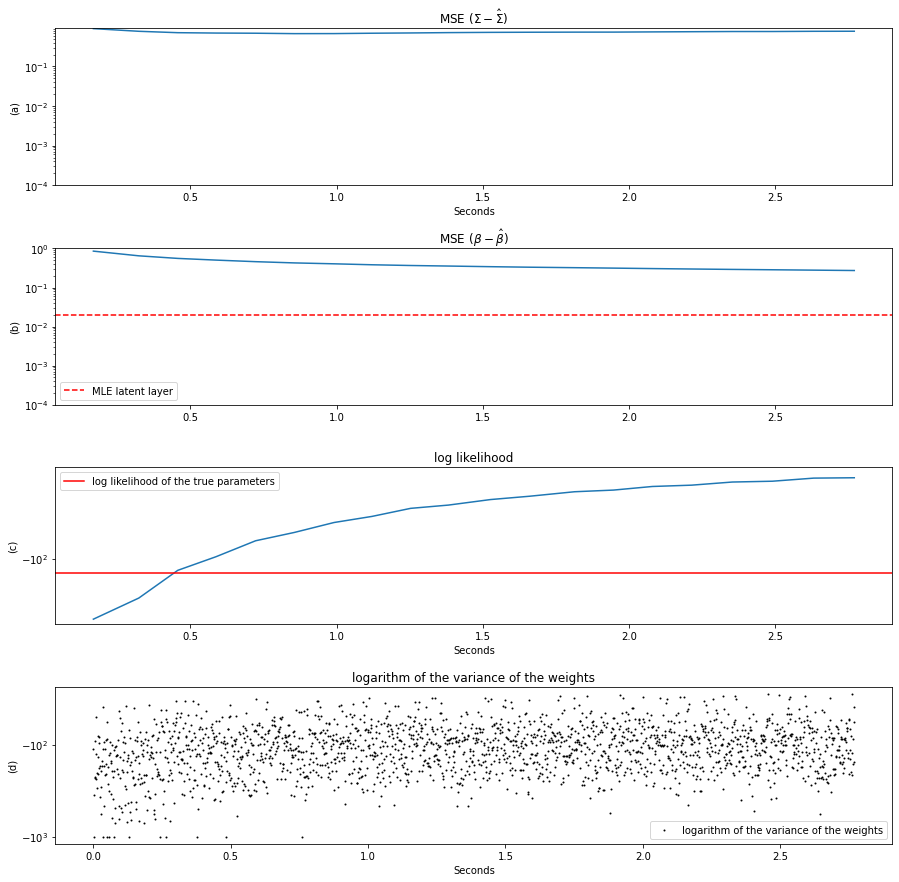

In [38]:
show(model, '', save = False)

log_f : tensor([[ -84.3989, -105.7347,  -90.1050,  ...,  -46.7578,  -51.4355,
          -83.1451],
        [ -83.0345, -103.2649,  -88.2417,  ...,  -45.0613,  -49.5447,
          -81.0894],
        [ -81.8474, -101.6119,  -86.4281,  ...,  -43.2918,  -48.0769,
          -80.0047],
        ...,
        [ -87.1268, -108.4659,  -92.7185,  ...,  -48.9541,  -53.0739,
          -84.9154],
        [ -82.0114, -101.3793,  -86.3345,  ...,  -43.4119,  -48.3669,
          -80.5109],
        [ -86.2630, -106.0226,  -89.8991,  ...,  -47.3530,  -52.3848,
          -85.0400]], grad_fn=<AddBackward0>)


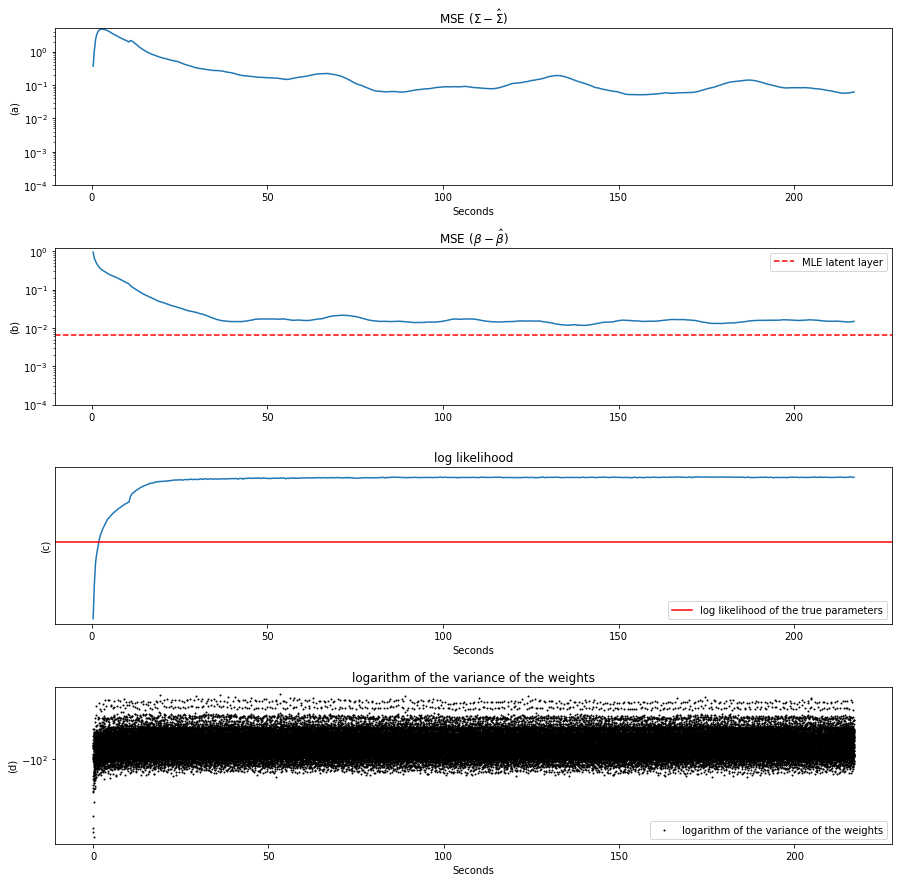

In [56]:
show(model, 'best,n=1000,p=30,q=10', save = False)

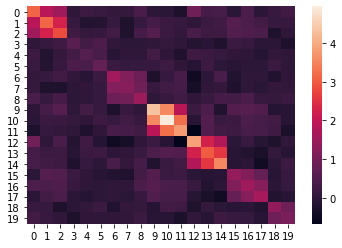

In [57]:
model.show_Sigma()

<AxesSubplot:>

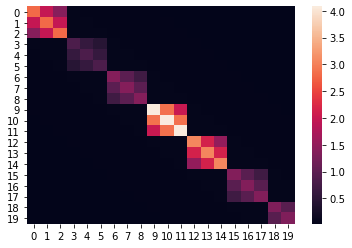

In [58]:
sns.heatmap(Sigma_sampling)

<AxesSubplot:title={'center':'$\\Sigma$'}>

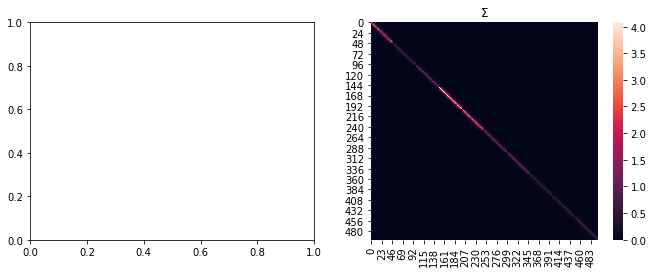

In [23]:
#mat = model.C_mean.detach().numpy()

fig,axes = plt.subplots(1,2,figsize = (11.2,4))
#axes[0].set_title(r'$\hat \Sigma$')
#sns.heatmap(mat@(mat.T),ax = axes[0])
axes[1].set_title(r'$\Sigma$')
sns.heatmap(Sigma_sampling,ax = axes[1])
#plt.savefig('best result Sigma')

<AxesSubplot:>

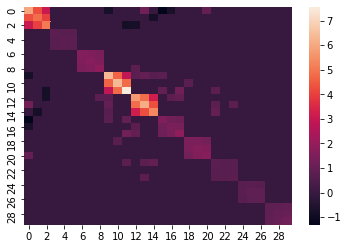

In [124]:
Sig = mat@(mat.T)
sns.heatmap(Sig * (np.abs(Sig) > 0.7))

In [91]:
torch.nan_to_num(torch.log(torch.from_numpy(model.var_weights[0:30])),neginf = -1000)

tensor([ -156.3740,  -190.7391,  -206.3035,  -177.1579,  -430.1877,  -530.9578,
         -286.1344,  -711.3682,  -690.1172,  -578.2244,  -128.1276,  -181.9416,
          -78.1325,  -338.8226,  -270.0796,  -652.3436, -1000.0000, -1000.0000,
         -234.5263,  -469.0022,  -149.7687, -1000.0000,  -489.5154,  -514.4129,
         -109.7870, -1000.0000,  -712.0253,  -155.6299, -1000.0000,  -145.8789])

<AxesSubplot:>

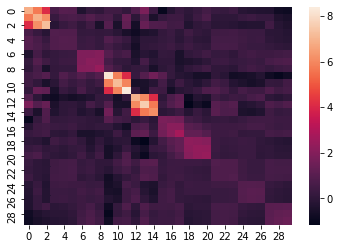

In [111]:
sns.heatmap((model.C_mean@(model.C_mean.T)).detach().numpy())

<AxesSubplot:>

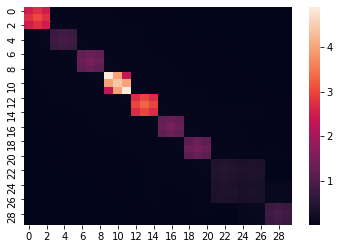

In [112]:
sns.heatmap(true_Sigma_sampling)

In [27]:
def show(model,name_doss , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.Will also plot the norm of the gradients and 
    the variance of the weights used for the importance sampling. 
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. It can also save the figure if save = True. 
    '''
    best_model = Basic_IMPS(q, average = 100, true_value = True)
    best_model.init_data(Y, O, covariates)
    best_model.Y_b,best_model.O_b, best_model.covariates_b, best_model.batch_size = Y, O, covariates, n
    best_log_like = best_model.infer_batch_p_theta(1000, 0.1, 1000)
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    #max_ = max(best_log_like,np.max(np.array(model.log_likelihood_list)))
    max_ = 0 
        
    d = model.beta.shape[0]
    #MSE of Sigma
    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
    #ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ', c = 'red', linestyle = '--')
    ax[0].set_xlabel('Seconds')
    ax[0].set_ylim(ymin= 1e-4)
    ax[0].set_ylabel('(a)')
    ax[0].set_yscale('log')
    
    #MSE of beta. 
    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
    ax[1].axhline(best_MSE_beta, label = 'MLE latent layer', c = 'red', linestyle = '--')
    ax[1].set_yscale('log')
    ax[1].set_ylim(ymin= 1e-4)
    ax[1].set_ylabel('(b)')
    ax[1].legend()
    
    #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
    ax[2].plot(abscisse, np.array(model.log_likelihood_list)-max_)
    ax[2].set_title('log likelihood')
    ax[2].set_ylabel('loglikelihood')
    ax[2].set_xlabel('Seconds')
    #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
    #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
    ax[2].axhline(best_log_like-max_, c = 'red', label = 'log likelihood of the true parameters')
    ax[2].set_yscale('symlog')
    ax[2].set_ylabel('(c)')
    ax[2].legend()
    
    ax[3].scatter(np.linspace(0,abscisse[-1], model.var_weights.shape[0]), 
                  torch.nan_to_num(torch.log(torch.from_numpy(model.var_weights)),neginf = -1000)
                  ,s = 1, label = 'logarithm of the variance of the weights', c = 'black')
    ax[3].set_title('logarithm of the variance of the weights')# '+ str(np.round(percentage_bad_beta,3)))
    ax[3].set_yscale('symlog')
    ax[3].set_ylabel('(d)')
    ax[3].set_xlabel('Seconds')
    ax[3].legend()
    if save : 
        plt.savefig(name_doss)
    plt.show()

log_f : tensor([[ -84.3989, -105.7347,  -90.1050,  ...,  -46.7578,  -51.4355,
          -83.1451],
        [ -83.0345, -103.2649,  -88.2417,  ...,  -45.0613,  -49.5447,
          -81.0894],
        [ -81.8474, -101.6119,  -86.4281,  ...,  -43.2918,  -48.0769,
          -80.0047],
        ...,
        [ -87.1268, -108.4659,  -92.7185,  ...,  -48.9541,  -53.0739,
          -84.9154],
        [ -82.0114, -101.3793,  -86.3345,  ...,  -43.4119,  -48.3669,
          -80.5109],
        [ -86.2630, -106.0226,  -89.8991,  ...,  -47.3530,  -52.3848,
          -85.0400]], grad_fn=<AddBackward0>)


NameError: name 'best_MSE_beta' is not defined

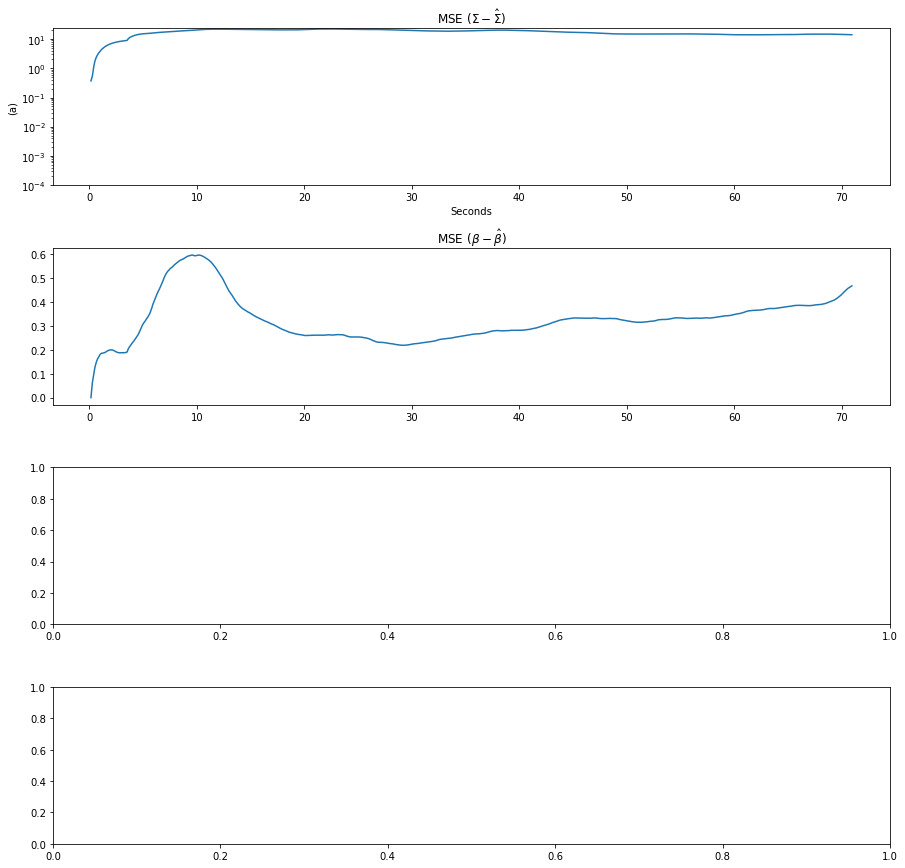

In [46]:
show(model, '')

MLE :


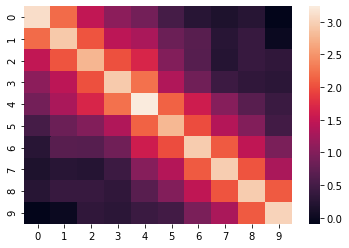

true Sigma


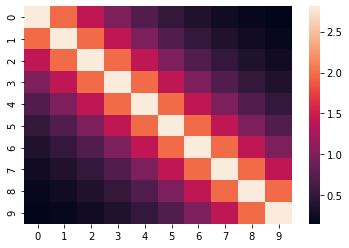

Best MSE we can have (in our dream):  tensor(0.0227)


In [29]:
## Here we plot the MLE for Z the latent variables. They are unknown in practice
## this is just to see the difference between our result and the best result possible 
mu_MLE = torch.mean(Z, dim = 0)
m = mu_MLE.shape[0]
Sigma_MLE = 1/Z.shape[0]*((Z-mu_MLE).T)@(Z-mu_MLE)
print('MLE :')
sns.heatmap(Sigma_MLE.to(torch.device('cpu')))
plt.show()
print('true Sigma')
sns.heatmap(Sigma_sampling.to(torch.device('cpu')))
plt.show()
best_MSE_Sigma = torch.mean((Sigma_MLE.to(device)-Sigma_sampling)**2)
print('Best MSE we can have (in our dream): ', best_MSE_Sigma)

In [30]:
target = Z+ torch.mm(covariates,true_beta)

clf = LinearRegression()
clf.fit(covariates,target)
beta_dream = torch.from_numpy(clf.coef_.T)
best_MSE_beta = torch.mean((beta_dream-true_beta)**2)
print('MSE beta in the latent layer: ', best_MSE_beta)

MSE beta in the latent layer:  tensor(0.0196)


In [31]:
from fastPLN import fastPLN
fastmodel = fastPLN()
%time fastmodel.fit(Y,O,covariates, 250)
print('MSE Sigma', torch.mean((fastmodel.Sigma-true_Sigma_sampling)**2))
print('MSE beta', torch.mean((fastmodel.beta-true_beta)**2))

device :  cpu
CPU times: user 360 ms, sys: 4.01 ms, total: 364 ms
Wall time: 365 ms
MSE Sigma tensor(0.1125, grad_fn=<MeanBackward0>)
MSE beta tensor(0.0177, grad_fn=<MeanBackward0>)


<AxesSubplot:>

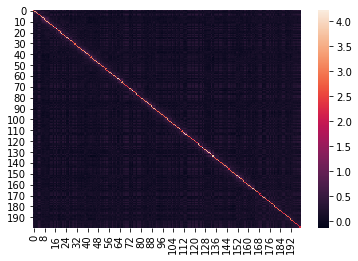

In [33]:
sns.heatmap(fastmodel.Sigma[0:200,0:200].detach())

<AxesSubplot:>

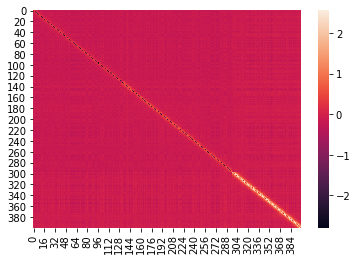

In [34]:
sns.heatmap((Sigma_sampling-fastmodel.Sigma)[200:600,200:600].detach())

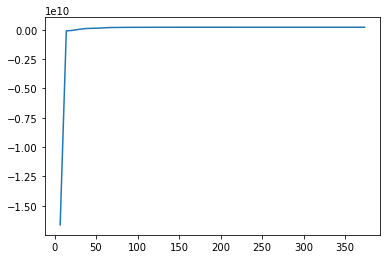

In [28]:
plt.plot(fastmodel.running_times, fastmodel.ELBO_list)

In [30]:
fastmodel.beta

tensor([[-1.4378e-01,  5.9384e-02,  5.6383e-02,  7.8254e-01, -1.9169e-01,
         -1.0719e-01, -1.4404e-01,  2.1642e-01,  1.2724e-01,  4.6581e-01,
         -7.6381e-02,  3.3575e-01, -2.6257e-01, -4.2131e-02, -4.3008e-01,
         -1.3453e-01,  4.3975e-01, -1.9500e-01, -1.3030e-01,  1.6599e-01,
          1.8961e-01,  6.5447e-02,  1.3495e-02, -6.7433e-01, -8.8611e-02,
          2.8640e-03, -1.1113e-01,  2.8274e-01, -2.8810e-01, -4.4610e-01,
         -1.7305e-01,  3.4154e-01,  2.4186e-01, -1.5015e-01, -1.1416e-01,
         -4.4246e-02, -2.9082e-01, -1.9032e-01,  3.1881e-01,  1.0805e-01,
         -1.4794e-01,  7.8668e-02,  2.5408e-01,  3.2574e-01,  1.4339e-01,
          2.2516e-01,  2.7646e-02, -1.1163e-02, -2.5448e-03,  3.2143e-01,
          1.1116e-01,  3.1532e-01, -5.0074e-01, -1.6516e-01, -1.9464e-01,
         -3.3426e-01,  4.0599e-01, -7.0797e-02,  2.4021e-01,  1.9292e-01,
          3.0238e-01,  1.0628e-01,  1.0017e-01,  2.2249e-01,  2.1344e-01,
         -3.7313e-01,  2.3939e-01,  2.

In [31]:
true_beta

tensor([[-1.4034e-01,  6.6023e-02,  6.7386e-02,  7.9302e-01, -1.8478e-01,
         -1.1928e-01, -1.5474e-01,  2.1400e-01,  1.2317e-01,  4.7018e-01,
         -7.1213e-02,  3.2946e-01, -2.6458e-01, -4.1022e-02, -4.2772e-01,
         -1.2875e-01,  4.4238e-01, -1.8795e-01, -1.3346e-01,  1.7288e-01,
          1.8986e-01,  6.0489e-02,  8.8402e-03, -6.8399e-01, -9.7895e-02,
          7.7152e-04, -1.1170e-01,  2.8736e-01, -2.8902e-01, -4.4466e-01,
         -1.6801e-01,  3.4013e-01,  2.5110e-01, -1.5167e-01, -1.0967e-01,
         -5.0301e-02, -2.9695e-01, -1.9664e-01,  3.0729e-01,  1.0906e-01,
         -1.5661e-01,  7.0874e-02,  2.4648e-01,  3.3079e-01,  1.4800e-01,
          2.1874e-01,  2.8755e-02, -1.2288e-02, -1.5739e-02,  3.1915e-01,
          1.0550e-01,  3.1272e-01, -4.9937e-01, -1.6968e-01, -1.9802e-01,
         -3.3528e-01,  4.0402e-01, -6.6685e-02,  2.4315e-01,  2.0114e-01,
          3.1313e-01,  1.1737e-01,  1.0762e-01,  2.3149e-01,  2.2150e-01,
         -3.7479e-01,  2.4513e-01,  2.